In [2]:
from Alice_Macros import *
from TreeOperations import *
import matplotlib.pylab as plt
import numpy as np
from scipy import sparse as sp
from scipy.stats import binom, poisson, rv_discrete, pearsonr, spearmanr, fisher_exact
from scipy.stats.distributions import hypergeom, norm
from statsmodels.stats.multitest import multipletests
from scipy.spatial.distance import squareform
import os
import bisect
import pickle
import sys
import ete3
import tqdm
import itertools
import warnings
import matplotlib
import seaborn as sns

In [3]:
mat_to_arr = lambda x: np.squeeze(np.asarray((x)))
def quick_tables_from_sparse(sp_table, target_ind, skip=0):
    """
        assuming columns are differant qualities 
        rows are observations
        sp_table is csr (population,n_qualities) sparse mat 
    """
    sp_target = sp_table[:, target_ind]
    sp_table = sp_table[:, skip:]
    has_a = mat_to_arr(sp_table.sum(axis=0))
    has_b = sp_target.sum()
    population, n_qualities = sp_table.shape
    
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        has_a_b = mat_to_arr(sp_table.multiply(sp_target).sum(axis=0))
        has_a_xb = mat_to_arr(sp_table.multiply((sp_target==0)*1).sum(axis=0))
        has_xa_b = mat_to_arr(has_b - has_a_b)
        has_xa_xb = mat_to_arr(population - has_a - has_xa_b)
    
    append = ~((has_a_b > 0) * (has_a_xb > 0) * (has_xa_b > 0) * (has_xa_xb > 0)) * .51
    has_a_b = has_a_b + append
    has_a_xb = has_a_xb + append
    has_xa_b = has_xa_b + append
    has_xa_xb = has_xa_xb + append   
    
    return (has_xa_xb, has_xa_b, has_a_xb, has_a_b)


from scipy.stats import chi2_contingency
chi2 = np.vectorize(lambda x: chi2_contingency(x)[:2])
def quick_chi2(sp_table, target_ind, skip=0):
    has_xa_xb, has_xa_b, has_a_xb, has_a_b = quick_tables_from_sparse(sp_table, target_ind, skip)
    z_d = (np.ndim(has_xa_xb) == 0)
    if z_d:
        has_xa_xb = [has_xa_xb]
        has_xa_b = [has_xa_b]
        has_a_xb = [has_a_xb]
        has_a_b = [has_a_b]
    fisher_input = pd.Series(list(zip(zip(has_xa_xb, has_a_xb), zip(has_xa_b, has_a_b))))
    fisher_unique, curr_inverse_ind = np.unique(fisher_input, return_inverse=True) #condence to uniq
    CurrRes = pd.DataFrame(np.vstack(chi2(fisher_unique)).T)
    CurrRes.columns = ['chi_stat','chi2_pval']
    CurrRes = CurrRes.iloc[curr_inverse_ind]
    if z_d:
        CurrRes['log_ods'] = np.log10((has_xa_xb[0] * has_a_b[0])/(has_xa_b[0] * has_a_xb[0]))
    else:
        CurrRes['log_ods'] = np.log10((has_xa_xb * has_a_b)/(has_xa_b * has_a_xb))
    return CurrRes.iloc[curr_inverse_ind]

In [4]:
def GetPhyloFisherScore(tree):
    # fisher only for page_having nodes
    data = sp.vstack([leaf.dat for leaf in tree])
    scores = []
    for i in tqdm.tqdm_notebook(range(data.shape[-1]-1), total=data.shape[-1]-1, desc='calc chi2'):
        table = quick_chi2(data, i, i+1)
        table['word_a'] = i
        table['word_b'] = list(range(i+1, i+1+len(table)))
        scores.append(table)    
    return pd.concat(scores, ignore_index=True)

In [5]:
def GetPhyloParallelScoreMat(tree):
    population = tree.size if 'size' in vars(tree) else (len(tree) * 2) - 1
    score = None
    abscore = None
    cont_one = None
    for i, cur_node in tqdm.tqdm_notebook(enumerate(tree.traverse()), total=population, desc='Score calc'):
        if not cur_node.is_root():
            
            state = (cur_node.dat > 0) * 1
            prev_state = (cur_node.up.dat  > 0) * 1
            event = (prev_state - state)
            cont_one_event = prev_state.multiply(state)
            event = event.multiply(event.T)
            cont_one_event = cont_one_event.multiply(cont_one_event.T)
            if score is None:
                cont_one = cont_one_event
                score = event
                abscore = abs(event)
            else:
                cont_one += cont_one_event
                score += event
                abscore += abs(event)
    
    cont_one = cont_one.toarray()
    np.fill_diagonal(cont_one, 0)
    
    abscore = abscore.toarray()
    np.fill_diagonal(abscore, 0)
        
    score = score.toarray()
    np.fill_diagonal(score, 0)
    return score, abscore, cont_one

In [6]:
def mean_para(tot_rate, population, branch_prop=None):
    x_ = [.5 * tot_rate, 1 - tot_rate, .5 * tot_rate]
    x = x_
    if branch_prop:
        for prop in branch_prop:
            branch_rate = tot_rate * prop
            x_ = np.array([.5 * branch_rate, 1 - branch_rate, .5 * branch_rate])
            x = np.convolve(x, x_)
    else:
        i = 1
        while i ** 2 < population:
            x = np.convolve(x, x)
            i *= 2
        while i < population:
            x = np.convolve(x, x_)
            i += 1

    z_ = np.argmax(x)
    x = x[z_:]
    x[1:] *= 2
    pvals_sf = dict(zip(range(len(x)), np.concatenate([[0], np.cumsum(x[::-1])])[::-1]))
    tail = np.vectorize(lambda y: pvals_sf[bisect.bisect_left(range(len(pvals_sf)), y)])
    return tail

In [7]:
def mean_coev(tot_rate, population, branch_prop=None):
    x_ = [1 - tot_rate, tot_rate]
    x = x_
    if branch_prop:
        for prop in branch_prop:
            branch_rate = tot_rate * prop
            x_ = np.array([1 - branch_rate, branch_rate])
            x = np.convolve(x, x_)
    else:
        i = 1
        while i ** 2 < population:
            x = np.convolve(x, x)
            i *= 2
        while i < population:
            x = np.convolve(x, x_)
            i += 1

    pvals_sf = dict(zip(range(len(x)), np.concatenate([[0], np.cumsum(x[::-1])])[::-1]))
    tail = np.vectorize(lambda y: pvals_sf[bisect.bisect_left(range(len(pvals_sf)), y)])
    return tail

In [8]:
def my_direct_coev_pval(p_rates, scores, population, branch_prop=None):
    p_rates, inver = np.unique(p_rates, return_inverse=True)
    
    res = []
    for curr_rate in tqdm.tqdm_notebook(p_rates, total=len(p_rates), desc='individual pvals conv'):
        x_ = np.array([1 - curr_rate, curr_rate])
        x = x_
        if branch_prop:
            for prop in branch_prop:
                branch_rate = curr_rate * prop
                x_ = np.array([1 - branch_rate, branch_rate])
                x = np.convolve(x, x_)
        else:
            i = 1
            while i ** 2 < population:
                x = np.convolve(x, x)
                i *= 2
            while i < population:
                x = np.convolve(x, x_)
                i += 1
        x = np.cumsum(x[::-1])[::-1]
        res.append(x)
    
    res = np.array(res)
    return res.take((inver * res.shape[1] + scores))

In [9]:
def my_direct_para_pval(p_rates, scores, population, branch_prop=None):
    p_rates, inver = np.unique(p_rates, return_inverse=True)
    
    res = []
    for curr_rate in tqdm.tqdm_notebook(p_rates, total=len(p_rates), desc='individual pvals conv'):
        x_ = np.array([.5 * curr_rate, 1 - curr_rate, .5 * curr_rate])
        x = x_
        if branch_prop:
            for prop in branch_prop:
                branch_rate = curr_rate * prop
                x_ = np.array([.5 * branch_rate, 1 - branch_rate, .5 * branch_rate])
                x = np.convolve(x, x_)
        else:
            i = 1
            while i ** 2 < population:
                x = np.convolve(x, x)
                i *= 2
            while i < population:
                x = np.convolve(x, x_)
                i += 1
        z_ = np.argmax(x)
        x = x[z_:]
        x[1:] *= 2
        x = np.cumsum(x[::-1])[::-1]
        res.append(x)
    res = np.array(res)
    return res.take((inver * res.shape[1] + scores))

In [10]:
def get_tables(tree, outpath):
    # calc scores 
    para, co_ev, cont_one = GetPhyloParallelScoreMat(tree)       
    
    # get pvals
    ind_rates = (tree.homoplasy_hist / tree.size)
    rate_mat = np.outer(ind_rates, ind_rates)
    np.fill_diagonal(rate_mat, 0)
    rate_mat = squareform(rate_mat)

    table_summary = pd.DataFrame()
    table_summary['cont_score'] =  squareform(cont_one).astype(np.int)
    table_summary['co_ev_score'] =  squareform(co_ev).astype(np.int)
    table_summary['para_score'] = squareform(para).astype(np.int)

    table_summary['direct_co_ev_pval'] = my_direct_coev_pval(rate_mat, table_summary['co_ev_score'], tree.size)
    table_summary['direct_para_pval'] = my_direct_para_pval(rate_mat, abs(table_summary['para_score']), tree.size)

    mean_dir = mean_coev((tree.homoplasy_hist.mean() / tree.size), tree.size)
    table_summary['mean_co_ev_pval'] = mean_dir(table_summary['co_ev_score'])

    mean_dir = mean_para((tree.homoplasy_hist.mean() / tree.size), tree.size)
    table_summary['mean_para_pval'] = mean_dir(abs(table_summary['para_score']))

    fisher_res = GetPhyloFisherScore(tree)
    table_summary = pd.concat([table_summary, fisher_res], axis=1)

    for col in [col for col in table_summary if 'pval' in col]:
        table_summary[col+'_corr'] = multipletests(table_summary[col].values, method='Bonferroni')[1]
        
    table_summary.to_parquet(outpath)
    return table_summary

In [11]:
def draw_homop(tree, savepath=None):
    import matplotlib.pylab as plt
    counts = pd.Series(tree.homoplasy_hist).value_counts(normalize=True).sort_index()
    plt.plot(counts.index.tolist(), counts.values.tolist())
    plt.xlabel('n_mutations')
    plt.ylabel('fracional')
    plt.title('tree mute rate distribution')
    if savepath:
        plt.savefig(savepath)
    else:
        plt.show()

In [12]:
def pval_hists(tables, pval_cols, cmap='rainbow', outpath=''):
    plt.close('all')
    plt.figure(figsize=(10,8))
    colors = plt.cm.get_cmap(cmap)(range(0, 255, 256//len(pval_cols)))
    with plt.style.context('default'):
        ax = plt.subplots(2)[1].ravel()
        ax[0].set_visible(False)
        ax = ax[-1]
        for col, color in zip(pval_cols, colors):
            ax.loglog(sorted(tables[col]), np.arange(len(tables)) / len(tables), label=col, color=color, basex=10, basey=10)
        ax.loglog(np.arange(len(tables)) / len(tables), np.arange(len(tables)) / len(tables), label='diag', basex=10, basey=10)
        ax.set_xlabel('pval cdf')
        ax.set_ylabel('population fraction')
        cell_text = spearmanr(tables[pval_cols])[0]
        cell_text = np.vectorize(lambda x: "{:.2e}".format(x))(cell_text)
        labels = pval_cols
        the_table = ax.table(cellText=cell_text,
                              colColours=colors,
                              colLabels=labels,
                              loc='top')

        if outpath:
            plt.savefig(outpath)
        else:
            plt.show()

In [13]:
def statistics(tree, outpath, make_new=False):
    if 'homoplasy_hist' not in vars(tree):
        from Analytical_solution_test_parallel import SetHomoplasy
        tree = SetHomoplasy(tree)
    if not make_new and os.path.exists(outpath):
        table = pd.read_parquet(outpath)
    else:
        table = get_tables(tree, outpath)
    # pval_hists(table, ['direct_conv_pval', 'direct_para_pval', 'mean_conv_pval', 'mean_para_pval', 'chi2_pval'])
    return table

In [14]:
import nltk
from process_wikipedia import remove_special_chars, remove_html_tags, clean_string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
def text_cleanup(text):
    text = remove_html_tags(text)
    text = remove_special_chars(text, ['\n', '–']+list(punctuation))
    text = clean_string(text, set(stopwords.words('english')))
    return text

stemm = PorterStemmer()
lemma = WordNetLemmatizer()
def tokanizer(text, ret_trans=True, unique=False):
    words = nltk.word_tokenize(text)
    words, inv_words = np.unique(words, return_inverse=True)
    word_trans_ = dict.fromkeys(words)
    for i in range(len(words)): 
        word_trans_[words[i]] = stemm.stem(lemma.lemmatize(words[i]))
        words[i] = word_trans_[words[i]]
    
    tokens, inv_tokens = np.unique(words, return_inverse=True)
    if not unique: tokens = (tokens[inv_tokens])[inv_words]
    tokens = tokens.tolist()
    if ret_trans:
        return (tokens, word_trans_)
    else:
        return tokens

In [15]:
import nltk
from nltk.corpus import wordnet as wn
import itertools
from functools import lru_cache
def bigram_dist(tree):
    text_bigrams = []
    for node in tqdm.tqdm_notebook(tree.traverse(), total=tree.size, desc='calc bigrams'):
        if not node.pageless:
            token_doc = tree.token_corp.doc2idx(tokanizer(node.text, unique=False, ret_trans=False))
            text_bigrams.append(nltk.bigrams(token_doc))
    fdist = nltk.FreqDist(itertools.chain(*text_bigrams))
    fdist = {k:v for k,v in fdist.items() if -1 not in k}
    # bigram to ordered sets
    fdist_new = {}
    for key, val in fdist.items():
        a,b = key
        a,b = (b,a) if a>b else (a,b)
        fdist_new[(a, b)] = fdist_new.get((a, b), 0) + val        
    return fdist_new


def simdist(tree, dist_func=wn.path_similarity):

    @lru_cache(maxsize=1000)
    def get_words(x):
        words_u = tree.token_to_word.get(tree.token_corp[x], [])
        words_u = [wn.synsets(word) for word in words_u]
        words_u = [word for sywords in words_u for word in sywords]
        return words_u
    
    @lru_cache(maxsize=1000)
    def token_dist(u,v):
        words_u = get_words(u)
        words_v = get_words(v)
        
        if not words_u or not words_v: return 0
        return max([(dist_func(u_w, u_v) or 0) for u_w in words_u for u_v in words_v])
    
    return token_dist
    

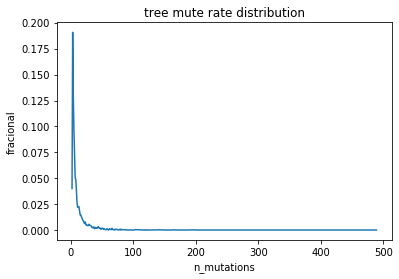

In [16]:
pickler = Tree_pickler()
tree_dir_no_tags = 'youtube_dataset/Saved_tree_no_tags'
table_path_no_tags = os.path.join(tree_dir_no_tags, 'statistic_table')
tree_no_tags = pickler.loadTree(tree_dir_no_tags)
table_no_tags = statistics(tree_no_tags, table_path_no_tags, make_new=False)
table_no_tags['zip_words'] = pd.Series(zip(table_no_tags['word_a'], table_no_tags['word_b']))
table_no_tags['abs_log_ods'] = abs(table_no_tags['log_ods'])


homop_path_no_tags = os.path.join(tree_dir_no_tags, 'homop.png')
draw_homop(tree_no_tags, homop_path_no_tags)

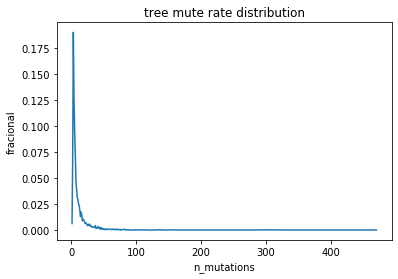

In [49]:
pickler = Tree_pickler()
tree_dir = 'youtube_dataset/Saved_tree'
table_path = os.path.join(tree_dir, 'statistic_table')
tree = pickler.loadTree(tree_dir)
table = statistics(tree, table_path, make_new=True)
table['zip_words'] = pd.Series(zip(table['word_a'], table['word_b']))
table['abs_log_ods'] = abs(table['log_ods'])

homop_path = os.path.join(tree_dir, 'homop.png')
draw_homop(tree, homop_path)

scores = ['chi_stat', 'cont_score', 'co_ev_score', 'para_score']
pvals = [col for col in table if ('pval' in col and 'corr' not in col)]
pvals_corr = [col for col in table if ('pval' in col and 'corr' in col)]

In [17]:
def top_n(table, columns, tree, N = 10, corr=True, ret_nums=False, ret_words=True, rev=False, return_loc=True):
    if rev:
        a = np.argsort(table[columns].values, axis=0)[-1:-1-N:-1]
    else:
        a = np.argsort(-table[columns].values, axis=0)[-1:-1-N:-1]
    b = pd.DataFrame(table[columns].index[a], columns=columns)
    values = pd.DataFrame(np.take_along_axis(table[columns].values, a, axis=0), columns=columns)
    ind_2_word = lambda x: tree.token_to_word[tree.token_corp[x]][0]
    row_to_pair = lambda x: tuple(list(map(ind_2_word, table.loc[x][['word_a', 'word_b']].values.astype(int))))
    row_to_num_pair = lambda x: tuple(list(table.loc[x][['word_a', 'word_b']].values.astype(int)))   
    if ret_words:
        words = b.applymap(row_to_pair)
        values = values.join(words, rsuffix='_words')
    if ret_nums:
        words = b.applymap(row_to_num_pair)
        values = values.join(words, rsuffix='_idx')
    if return_loc:
        values = values.join(pd.DataFrame(a, columns=columns), rsuffix='_loc') 
    values = values[sorted(values.columns)]
    return values

In [18]:
def a_b_comp(table, tree, col_a, col_b, N = 100, max_min=False, max_max=False, min_min=False, min_max=False, more_cols=[]):
    added_cols = [ 'word_a', 'word_b', 'chi_stat', 'cont_score', 'co_ev_score', 'para_score']+more_cols
    added_cols = [col for col in added_cols if col!=col_a and col!=col_b]
    values = table[[col_a, col_b]+added_cols]
    if max_min or max_max:
        values = table[[col_a, col_b]+added_cols].nlargest(N, col_a)
    elif min_max or min_min:
        values = table[[col_a, col_b]+added_cols].nsmallest(N, col_a)
    else:
        values = values.iloc[:N]
        
    if min_max or max_max:
        values = values.sort_values(col_b, ascending=False)
    elif max_min or min_min:
        values = values.sort_values(col_b, ascending=True)
    
    ind_2_word = lambda x: tree.token_to_word[tree.token_corp[x]][0]
    values[['word_a', 'word_b']] = values[['word_a', 'word_b']].applymap(ind_2_word)
    return values

In [53]:
top_n(table, pvals_corr, tree, 100, rev=False)

chi2_pval_corr     chi2_pval_corr_words  direct_co_ev_pval_corr  \
0              0.0         (barr, roseanne)            7.037428e-91   
1              0.0      (elders, hollywood)            5.788490e-75   
2              0.0         (brooker, laura)            1.177354e-74   
3              0.0  (brooker, professional)            3.850706e-68   
4              0.0          (brooker, wish)            7.224798e-61   
..             ...                      ...                     ...   
95             0.0      (irvine, evergreen)            2.809785e-24   
96             0.0    (keenan, pyeongchang)            3.086630e-24   
97             0.0     (smallfoot, bowling)            6.313641e-24   
98             0.0           (adults, time)            6.843981e-24   
99             0.0     (mamma, pyeongchang)            1.878516e-23   

   direct_co_ev_pval_corr_words  direct_para_pval_corr  \
0                (angeles, los)          3.896153e-107   
1               (donald, trump)           6.400495e-91   
2                    (hip, hop)           4.276779e-86   
3              (super, bowling)           2.725180e-82   
4              (scenes, behind)           8.935910e-80   
..                          ...                    ...   
95            (show, degeneres)           4.692694e-30   
96             (ronan, saoirse)           5.628623e-30   
97               (north, korea)           1.053409e-29   
98           (funny, hilarious)           5.189929e-29   
99                (show, ellen)           1.038000e-28   

   direct_para_pval_corr_words  mean_co_ev_pval_corr  \
0               (angeles, los)          9.405227e-27   
1              (donald, trump)          4.412132e-22   
2                   (hip, hop)          1.421312e-20   
3             (super, bowling)          4.067243e-14   
4                  (new, york)          9.241967e-13   
..                         ...                   ...   
95                (moore, roy)          1.000000e+00   
96          (funny, hilarious)          1.000000e+00   
97           (luke, skywalker)          1.000000e+00   
98               (west, kanye)          1.000000e+00   
99         (boseman, chadwick)          1.000000e+00   

   mean_co_ev_pval_corr_words  mean_para_pval_corr mean_para_pval_corr_words  
0              (music, video)         7.348865e-49            (music, video)  
1                 (new, york)         2.278893e-42               (new, york)  
2             (comedy, funny)         3.655286e-38           (comedy, funny)  
3                 (war, star)         4.638364e-31               (war, star)  
4           (official, video)         4.015267e-28            (angeles, los)  
..                        ...                  ...                       ...  
95             (lizza, mulan)         7.527217e-01        (marvel, avengers)  
96           (lizza, purpose)         7.527217e-01          (fashion, style)  
97              (lizza, dodo)         7.527217e-01               (show, the)  
98             (lizza, their)         1.000000e+00             (lizza, ball)  
99            (lizza, wiseau)         1.000000e+00          (lizza, demille)  

[100 rows x 10 columns]

In [50]:
top_n(bigrams_table, pvals_corr, tree, 100)

chi2_pval_corr     chi2_pval_corr_words  direct_co_ev_pval_corr  \
0     1.408956e-24    (universities, press)            1.671546e-73   
1     4.060618e-19    (every, displaystyle)            1.082211e-41   
2     5.089277e-17  (general, displaystyle)            6.980925e-35   
3     1.472526e-14            (cdots, frac)            1.232496e-34   
4     1.305892e-12     (form, displaystyle)            4.614805e-32   
..             ...                      ...                     ...   
95    1.000000e+00    (point, displaystyle)            6.697910e-03   
96    1.000000e+00      (point, coordinate)            8.693344e-03   
97    1.000000e+00        (point, distance)            1.032656e-02   
98    1.000000e+00           (point, fixed)            1.042812e-02   
99    1.000000e+00              (new, york)            1.754126e-02   

   direct_co_ev_pval_corr_words  direct_para_pval_corr  \
0                    (can, not)          4.546060e-150   
1                  (kluwer, bv)           1.309564e-64   
2               (neumanns, von)           3.090131e-61   
3       (compass, straightedge)           3.460086e-56   
4           (academics, kluwer)           7.364822e-52   
..                          ...                    ...   
95             (isbn, springer)           1.088202e-18   
96          (angles, triangles)           1.507690e-18   
97          (equate, quadratic)           1.519886e-18   
98        (algebra, geometries)           1.777874e-18   
99             (applied, rules)           3.274583e-18   

   direct_para_pval_corr_words  mean_co_ev_pval_corr  \
0                   (can, not)          6.065789e-91   
1              (centuries, th)          8.903483e-50   
2                 (kluwer, bv)          2.985683e-47   
3              (neumanns, von)          1.951889e-36   
4          (academics, kluwer)          2.735515e-30   
..                         ...                   ...   
95          (euclidean, space)          1.339583e-05   
96         (consistent, proof)          1.339583e-05   
97       (algebra, geometries)          1.339583e-05   
98                (every, set)          1.339583e-05   
99      (spherical, triangles)          1.339583e-05   

   mean_co_ev_pval_corr_words  mean_para_pval_corr mean_para_pval_corr_words  
0                  (can, not)        7.051066e-168                (can, not)  
1             (centuries, th)         4.197036e-94           (centuries, th)  
2           (difference, way)         3.250521e-85         (difference, way)  
3               (order, well)         4.220786e-61               (early, th)  
4                 (early, th)         6.471465e-55          (external, isbn)  
..                        ...                  ...                       ...  
95          (finite, present)         2.948687e-18    (follow, displaystyle)  
96                (new, york)         2.948687e-18          (line, parallel)  
97            (problem, word)         2.948687e-18      (displaystyle, case)  
98        (problem, solution)         2.948687e-18      (negative, position)  
99           (call, function)         1.009451e-17           (space, vector)  

[100 rows x 10 columns]

In [ ]:
a_b_comp(table, tree, 'direct_para_pval', 'chi2_pval', min_max=True)

In [ ]:
a_b_comp(table, tree, 'direct_co_ev_pval', 'chi2_pval', min_max=True)

In [ ]:
a_b_comp(table, tree, 'chi2_pval', 'direct_para_pval', min_max=True)

In [ ]:
more_cols = ['chi2_pval_corr','direct_co_ev_pval_corr']
a_b_comp(table, tree, 'cont_score', 'direct_para_pval_corr', 1000, more_cols=more_cols, max_max=True)

In [ ]:
# make graph
import seaborn as sns
def Draw_ab(table, col_a, col_b, N=int(1e5), log=False, pval=False, kind=None):
    plot_table = table[[col_a, col_b]].sample(min(N, len(table)))
    if log: plot_table = np.log10(plot_table)
    if pval: plot_table = plot_table[(plot_table < (0 if log else 1)).all(axis=1)]
    sns.jointplot(data=plot_table, x=col_a, y=col_b, kind=kind)
    plt.show()

In [ ]:
Draw_ab(table, 'direct_para_pval_corr', 'chi2_pval_corr', log=True, pval=True, kind='scatter', N=int(5e5))

In [ ]:
Draw_ab(table, 'log_ods', 'para_score', log=False, pval=False, kind='scatter', N=int(5e5))

In [ ]:
a_b_comp(table, tree, 'para_score', 'log_ods', max_min=True, more_cols=['direct_para_pval_corr', 'chi2_pval_corr'])

# Word Cloud

In [19]:
no_tags = True

In [20]:
usetable = table_no_tags if no_tags else table
usetree = tree_no_tags if no_tags else tree
scores = ['chi_stat', 'cont_score', 'co_ev_score', 'para_score', 'log_ods']
pvals = [col for col in usetable if ('pval' in col and 'corr' not in col)]
pvals_corr = [col for col in usetable if ('pval' in col and 'corr' in col)]

In [21]:
def filter_concept(table, tree, topic):
    ind = usetree.token_corp.doc2idx([usetree.word_to_token[topic]])[0]
    if no_tags:
        return usetable[(usetable['word_a'] == ind) + (usetable['word_b'] == ind)]
    else:
        return usetable[(usetable['word_a'] == ind) + (usetable['word_b'] == ind)]

In [22]:
import wordcloud as wc
from IPython.core.display import HTML
import matplotlib.pylab as plt
import numpy as np
import matplotlib.patheffects as PathEffects
from matplotlib import cm

In [23]:
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet_ic
from functools import partial
# brown_ic =  wordnet_ic.ic('ic-brown.dat')
# sim_func = partial(wn.lin_similarity, ic=brown_ic)
dist_func = simdist(usetree, dist_func=wn.wup_similarity)

In [24]:
def colorFader(c1,c2): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(matplotlib.colors.to_rgb(c1))
    c2=np.array(matplotlib.colors.to_rgb(c2))
    def fader_cmap(mix):
        return matplotlib.colors.to_rgba((1-mix)*c1 + mix*c2)
    return fader_cmap

In [25]:
def WordCloudFreq(title, freq_dict, word_to_color=None, circle=False, repeat=True, center_text=False, title_size=50):
    
    mask = None
    if circle:
        x, y = np.ogrid[:300, :300]
        mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
        mask = 255 * mask.astype(int)

    wc_class = wc.WordCloud(background_color='white', mask=mask, repeat=repeat)
    wordcloud = wc_class.generate_from_frequencies(freq_dict) 
    
    if word_to_color:
        wordcloud.recolor(color_func=word_to_color)
        score = []
        for word in freq_dict:
            word_ind = usetree.token_corp.token2id[usetree.word_to_token[word]]
            score.append(freq_dict[word]*dist_func(title_ind, word_ind))
        score = np.sum(score) / np.sum(list(freq_dict.values()))
            
    plt.imshow(wordcloud)#, interpolation="bilinear")
    if center_text:
        if circle:
            w, h = 150, 150
        else:
            w, h = wordcloud.width/2, wordcloud.height/2 
        txt = plt.text(30, 30, '#'+title, fontsize=title_size, ha='center', va='center', alpha=1)
        txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
        if word_to_color: 
            score_text = '{:.2e}'.format(float(score))
            txt = plt.text(w, 2*h, 'weighted avg score: '+score_text, fontsize=15, ha='center', va='bottom')
    else:
        plt.title(title, fontsize=title_size)
    plt.axis("off")

In [50]:
target = 'trump'
title_ind = usetree.token_corp.token2id[usetree.word_to_token[target]] 
#tree.token_corp.token2id[tree.word_to_token[target]]

In [51]:
sig_thresh = 5e-2
top_5 = int(len(usetree.token_corp) * sig_thresh)

In [52]:
to_int_color = lambda x: int(max(0, min(255, np.floor(x * 256.0))))
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
cmap = plt.cm.ScalarMappable(norm=norm, cmap=cm.RdYlGn)
def my_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    word_ind = usetree.token_corp.token2id[usetree.word_to_token[word]]
    return tuple(map(to_int_color, cmap.to_rgba((dist_func(title_ind, word_ind)))))

In [53]:
filter_table = filter_concept(usetable, usetree, target)
target_table = top_n(filter_table, pvals_corr, usetree, top_5, ret_nums=True, rev=False)
for col in pvals_corr:
    lowest = target_table['chi2_pval_corr'].unique()[:2]
    if lowest[0] == 0:
        target_table[col] = target_table[col].replace(0, lowest[1])
        
target_table['log_ods'] = filter_table.iloc[target_table['chi2_pval_corr_loc'].values]['log_ods'].values
target_table['para_score'] = filter_table.iloc[target_table['direct_para_pval_corr_loc'].values]['para_score'].values

/media/kishonylab/KishonyStorage/galn/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:193: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  op=op_str, alt_op=unsupported[op_str]


In [54]:
# caution heavy procedure
filter_table['wup_sim'] = None
wup_sim = []
for x in tqdm.tqdm_notebook(filter_table['zip_words'], total=len(filter_table)):
    wup_sim.append(dist_func(x[0], x[1]))
filter_table['wup_sim'] = wup_sim

/media/kishonylab/KishonyStorage/galn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/media/kishonylab/KishonyStorage/galn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 0.98, '#trump Chi2-Test')

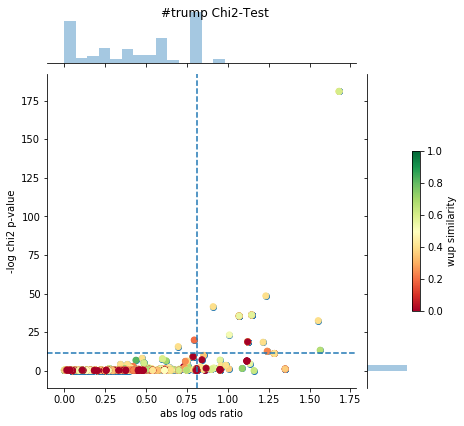

In [55]:
"""
plt.close('all')
splot = sns.jointplot(x=filter_table['abs_log_ods'], y=-np.log10(filter_table['chi2_pval'].replace(0,1e-6)))
splot.ax_joint.scatter(x=filter_table['abs_log_ods'], y=-np.log10(filter_table['chi2_pval'].replace(0,1e-6)), color=cmap.to_rgba(filter_table['wup_sim']))

splot.ax_joint.set_xlabel('abs log ods ratio')
splot.ax_joint.set_ylabel('-log chi2 p-value')
cb = plt.colorbar(cmap, ax=None, shrink=.6)
cb.set_label('wup similarity')
plt.suptitle('#'+target)
"""
plt.close('all')
splot = sns.jointplot(x=filter_table['abs_log_ods'], y=-np.log10(filter_table['chi2_pval'].replace(0,1e-6)))
splot.ax_joint.scatter(x=filter_table['abs_log_ods'], y=-np.log10(filter_table['chi2_pval'].replace(0,1e-6)), color=cmap.to_rgba(filter_table['wup_sim']))

splot.ax_joint.set_xlabel('abs log ods ratio')
splot.ax_joint.set_ylabel('-log chi2 p-value')

splot.ax_joint.axvline(x=filter_table['abs_log_ods'].quantile(.95), linestyle='--')

thresh = max(-np.log10(filter_table['chi2_pval_corr']).quantile(.95), -np.log(5e-2))
rel_filt = -np.log10(filter_table['chi2_pval'][-np.log10(filter_table['chi2_pval_corr']) > thresh].max())
splot.ax_joint.axhline(y=rel_filt, linestyle='--')

cb = plt.colorbar(cmap, ax=None, shrink=.6)
cb.set_label('wup similarity')
plt.suptitle('#'+target+' Chi2-Test')

Text(0.5, 0.98, '#trump Tree-Test')

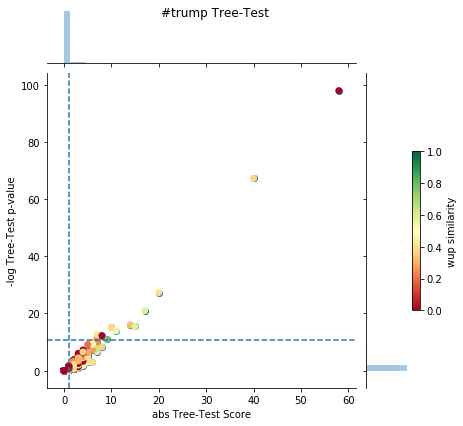

In [58]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.close('all')
splot = sns.jointplot(x=np.abs(filter_table['para_score']), y=-np.log10(filter_table['direct_para_pval']))
splot.ax_joint.scatter(x=np.abs(filter_table['para_score']), y=-np.log10(filter_table['direct_para_pval']), color=cmap.to_rgba(filter_table['wup_sim']))

splot.ax_joint.set_xlabel('abs Tree-Test Score')
splot.ax_joint.set_ylabel('-log Tree-Test p-value')

splot.ax_joint.axvline(x=filter_table['para_score'].quantile(.95), linestyle='--')

thresh = max(-np.log10(filter_table['direct_para_pval_corr']).quantile(.95), -np.log(5e-2))
rel_filt = -np.log10(filter_table['direct_para_pval'][-np.log10(filter_table['direct_para_pval_corr']) > thresh].max())
splot.ax_joint.axhline(y=rel_filt, linestyle='--')

cb = plt.colorbar(cmap, shrink=.6)
cb.set_label('wup similarity')
plt.suptitle('#'+target+' Tree-Test')

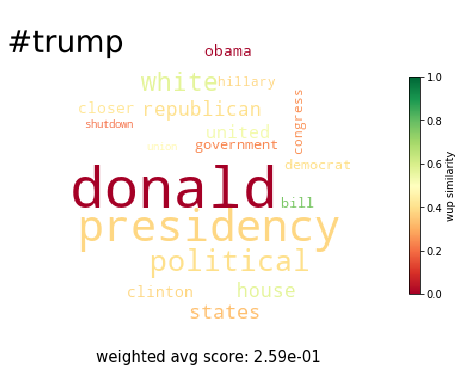

In [59]:
target_table_para = target_table[target_table['para_score'] > 0]
target_table_para = target_table_para[target_table_para['direct_para_pval_corr'] < sig_thresh]
words = target_table_para['direct_para_pval_corr_words'].apply(lambda x: x[0 if x[1]==target else 1]).values
freq = -np.log10(target_table_para['direct_para_pval_corr']).values

plt.close('all')
plt.figure(figsize=(8,8))
WordCloudFreq(target, dict(zip(words,freq)), word_to_color=my_color_func, circle=True, center_text=True, title_size=30, repeat=False)
cb = plt.colorbar(cmap, shrink=.5)
cb.set_label('wup similarity')
suf = '_no_tags' if no_tags else ''
#plt.savefig(table_path+'_'+target+'_para_clust'+suf+'.png')
plt.show()

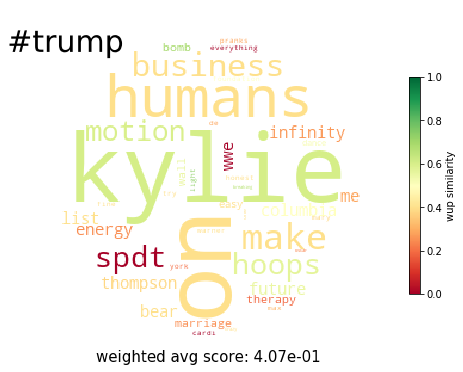

In [60]:
target_table_chi = target_table[target_table['log_ods'] > 0]
target_table_chi = target_table_chi[target_table_chi['chi2_pval_corr'] < sig_thresh]
words = target_table_chi['chi2_pval_corr_words'].apply(lambda x: x[0 if x[1]==target else 1]).values
freq = -np.log10(target_table_chi['chi2_pval_corr']).values

plt.close('all')
plt.figure(figsize=(8,8))
WordCloudFreq(target, dict(zip(words,freq)), word_to_color=my_color_func, circle=True, center_text=True, title_size=30, repeat=False)
cb = plt.colorbar(cmap, shrink=.5)
cb.set_label('wup similarity')
suf = '_no_tags' if no_tags else ''
#plt.savefig(table_path+'_'+target+'_chi2_clust'+suf+'.png')
plt.show()

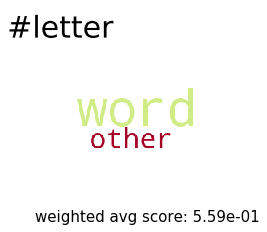

In [260]:
WordCloudFreq('letter', dict({'word':1, 'other':.1}), word_to_color=my_color_func, circle=True, center_text=True, title_size=30, repeat=False)

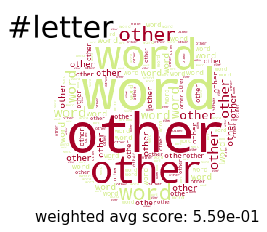

In [261]:
WordCloudFreq('letter', dict({'word':1, 'other':.1}), word_to_color=my_color_func, circle=True, center_text=True, title_size=30, repeat=True)

# Tree Plotter

In [159]:
us_videos_first = pd.read_parquet('youtube_dataset/USfirst.parq')
for leaf in tree:
    leaf.id = leaf.name
    leaf.name = us_videos_first.iloc[int(leaf.name)]['title']
for leaf in tree_no_tags:
    leaf.id = leaf.name
    leaf.name = us_videos_first.iloc[int(leaf.name)]['title']   

In [142]:
from ete3 import faces, TreeStyle
os.environ['QT_QPA_PLATFORM']='offscreen'

In [143]:
def Rect_wiki(ind_a, ind_b, size=3, low_opticy=0.1, show_names=False):
    # Import Tree instance and faces module
    gen_color  = "Salmon"
    phen_color = "RoyalBlue"
    rand_color = "Lime"

    # Creates my own layout function.
    def mylayout(node):
        # mark counted

        gene_face = faces.RectFace(size, size, bgcolor=gen_color, fgcolor=None)
        phen_face = faces.RectFace(size, size, bgcolor=phen_color, fgcolor=None)
        gene_face.opacity = 1 if node.dat[0, ind_a] else low_opticy
        phen_face.opacity = 1 if node.dat[0, ind_b] else low_opticy

        if show_names:
            F = faces.TextFace(node.name, tight_text=True)
            faces.add_face_to_node(F, node, column=2, position="branch-top")
        
        faces.add_face_to_node(gene_face, node, column=0)
        faces.add_face_to_node(phen_face, node, column=1)
        node.img_style["size"] = 0

    # And, finally, Visualize the tree using my own layout function
    ts = TreeStyle()
    ts.layout_fn = mylayout
    #ts.mode = 'c'
    ts.show_leaf_name = True
    ts.rotation = 90
    return ts

In [160]:
sin_ind = tree_no_tags.token_corp.token2id[tree_no_tags.word_to_token['trump']]
euler_ind = tree_no_tags.token_corp.token2id[tree_no_tags.word_to_token['kylie']]
newick = tree_no_tags.render(table_path+'_trump_kylie_tree.svg', w=40000, tree_style = Rect_wiki(sin_ind, euler_ind, size=10, low_opticy=0.2, show_names=True))

In [63]:
sin_ind = tree.token_corp.token2id[tree.word_to_token['trump']]
euler_ind = tree.token_corp.token2id[tree.word_to_token['kylie']]
newick =tree.render(table_path+'_trump_kylie_tree.png', w=40000, tree_style = Rect_wiki(sin_ind, euler_ind, size=10, low_opticy=0.2, show_names=True))

{'nodes': [],
 'faces': [[9973.369463651654,
   9309.94206690338,
   9982.713511493179,
   9319.286114744906,
   0,
   None],
  [9973.369463651654,
   9319.286114744906,
   9982.713511493179,
   9328.63016258643,
   0,
   None],
  [9978.041487572416,
   9225.845636329657,
   9988.319940198093,
   9309.94206690338,
   0,
   'Mathematics'],
  [19937.394879461783,
   9461.315641936086,
   19946.738927303308,
   9470.65968977761,
   1,
   None],
  [19937.394879461783,
   9470.65968977761,
   19946.738927303308,
   9480.003737619136,
   1,
   None],
  [19942.066903382543,
   9328.63016258643,
   19952.345356008223,
   9461.315641936086,
   1,
   'Pseudomathematics'],
  [19981.31190431695,
   9603.345169127264,
   19990.655952158475,
   9612.689216968789,
   2,
   None],
  [19981.31190431695,
   9612.689216968789,
   19990.655952158475,
   9622.033264810314,
   2,
   None],
  [19985.98392823771,
   9480.003737619136,
   19999.06559521585,
   9603.345169127264,
   2,
   'Squaring the circle']

In [68]:
sin_ind = tree.token_corp.token2id['sin']
co_ind = tree.token_corp.token2id['co']
newick = tree.render(tree_path+'_sin_cos_tree.png', w=20000, tree_style = Rect_wiki(sin_ind, co_ind, size=10, low_opticy=0.2, show_names=True))

{'nodes': [],
 'faces': [[9973.369463651654,
   9309.94206690338,
   9982.713511493179,
   9319.286114744906,
   0,
   None],
  [9973.369463651654,
   9319.286114744906,
   9982.713511493179,
   9328.63016258643,
   0,
   None],
  [9978.041487572416,
   9225.845636329657,
   9988.319940198093,
   9309.94206690338,
   0,
   'Mathematics'],
  [19937.394879461783,
   9461.315641936086,
   19946.738927303308,
   9470.65968977761,
   1,
   None],
  [19937.394879461783,
   9470.65968977761,
   19946.738927303308,
   9480.003737619136,
   1,
   None],
  [19942.066903382543,
   9328.63016258643,
   19952.345356008223,
   9461.315641936086,
   1,
   'Pseudomathematics'],
  [19981.31190431695,
   9603.345169127264,
   19990.655952158475,
   9612.689216968789,
   2,
   None],
  [19981.31190431695,
   9612.689216968789,
   19990.655952158475,
   9622.033264810314,
   2,
   None],
  [19985.98392823771,
   9480.003737619136,
   19999.06559521585,
   9603.345169127264,
   2,
   'Squaring the circle']

In [154]:
tree_no_tags.render('%%inline', w=40000, tree_style = Rect_wiki(sin_ind, euler_ind, size=10, low_opticy=0.2, show_names=True))

In [164]:
us_videos_first[us_videos_first['title'] == 'Nick Jonas - Home']['tags'].values

array(['Nick Jonas|"Home"|"Ferdinand"|"Nick"|"Jonas"|"Island"|"Records"|"Soundtrack"'],
      dtype=object)